In [34]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

In [35]:
df_ret = pd.read_feather('data/nasdaq_etfs.feather')
df_ret.head() # contains daily percentage returns (NOTE: 0.747 means 0.747% not 74.7%)

Ticker,AAXJ,ACWI,ACWX,AFK,AGQ,AIA,AIVI,AIVL,AOA,AOK,...,XRT,XSD,XSMO,XSVM,YANG,YCL,YCS,YINN,YXI,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-13,0.747621,1.562114,1.686754,1.853138,2.700842,0.854489,1.788925,1.268345,1.884208,0.435343,...,2.734448,2.155864,3.351985,3.351523,-2.632439,0.140403,-0.369203,2.300923,-0.936347,-2.774568
2010-07-14,-0.380087,0.372102,0.263322,0.034330,1.457285,0.051332,0.051002,-0.168632,-0.470754,0.000000,...,-0.452477,0.065970,0.154452,-0.603311,2.571722,0.385555,-0.476437,-2.663477,1.155257,-1.634958
2010-07-15,-0.763130,0.098904,0.157541,0.274559,-0.511807,-0.821128,1.603865,0.192969,-0.135120,0.108410,...,0.588216,-0.131862,-0.462618,0.379324,2.828656,1.815644,-1.968086,-2.827608,0.000000,0.302206
2010-07-16,-2.453279,-2.765485,-2.884077,-1.540060,-4.829074,-2.664938,-2.706147,-2.167090,-2.063619,-0.721728,...,-3.561905,-2.947607,-3.718039,-3.930446,5.470490,2.023320,-1.627784,-5.882389,3.612906,5.122025
2010-07-19,1.144909,0.634864,0.539948,-0.451860,-2.580644,1.302489,0.566597,1.058404,0.207255,0.072730,...,0.385863,2.606528,0.402229,0.393409,-2.874933,-0.336136,0.386099,3.158260,-0.420834,2.694180


In [36]:
growth = 1 + df_ret/100
prices = growth.cumprod().shift(1, fill_value=1)
prices

Ticker,AAXJ,ACWI,ACWX,AFK,AGQ,AIA,AIVI,AIVL,AOA,AOK,...,XRT,XSD,XSMO,XSVM,YANG,YCL,YCS,YINN,YXI,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2010-07-14,1.007476,1.015621,1.016868,1.018531,1.027008,1.008545,1.017889,1.012683,1.018842,1.004353,...,1.027344,1.021559,1.033520,1.033515,0.973676,1.001404,0.996308,1.023009,0.990637,0.972254
2010-07-15,1.003647,1.019400,1.019545,1.018881,1.041975,1.009063,1.018408,1.010976,1.014046,1.004353,...,1.022696,1.022233,1.035116,1.027280,0.998716,1.005265,0.991561,0.995762,1.002081,0.956358
2010-07-16,0.995988,1.020409,1.021151,1.021678,1.036642,1.000777,1.034742,1.012927,1.012676,1.005442,...,1.028712,1.020885,1.030328,1.031177,1.026966,1.023517,0.972046,0.967605,1.002081,0.959249
2010-07-19,0.971553,0.992189,0.991701,1.005944,0.986582,0.974107,1.006741,0.990976,0.991778,0.998186,...,0.992070,0.990793,0.992020,0.990647,1.083146,1.044226,0.956224,0.910687,1.038285,1.008381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-07,2.015967,4.446915,2.440356,1.106377,0.425254,2.942018,2.416690,4.474508,4.044077,2.002599,...,5.425686,12.937034,6.124074,5.511386,0.000453,0.200948,2.947960,0.069609,0.250753,0.004476
2025-07-08,1.984048,4.408199,2.412865,1.104771,0.423017,2.894811,2.384780,4.443185,4.011100,1.991288,...,5.379256,12.590050,6.024331,5.440284,0.000452,0.198227,3.000703,0.069680,0.251442,0.004501
2025-07-09,1.997590,4.415737,2.426411,1.097278,0.420523,2.915712,2.397743,4.442402,4.019829,1.991288,...,5.369835,12.860903,6.033158,5.461615,0.000439,0.197174,3.025316,0.071677,0.248457,0.004523


In [37]:
# Log Prices
log_prices = np.log(prices)
log_prices.head()

Ticker,AAXJ,ACWI,ACWX,AFK,AGQ,AIA,AIVI,AIVL,AOA,AOK,...,XRT,XSD,XSMO,XSVM,YANG,YCL,YCS,YINN,YXI,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-07-14,0.007448,0.015500,0.016727,0.018362,0.026650,0.008509,0.017731,0.012604,0.018667,0.004344,...,0.026977,0.021330,0.032970,0.032966,-0.026677,0.001403,-0.003699,0.022749,-0.009408,-0.028138
2010-07-15,0.003640,0.019215,0.019357,0.018705,0.041118,0.009022,0.018241,0.010916,0.013948,0.004344,...,0.022442,0.021989,0.034514,0.026914,-0.001285,0.005251,-0.008475,-0.004247,0.002079,-0.044623
2010-07-16,-0.004020,0.020203,0.020931,0.021447,0.035987,0.000777,0.034152,0.012844,0.012596,0.005427,...,0.028307,0.020670,0.029877,0.030701,0.026609,0.023245,-0.028352,-0.032931,0.002079,-0.041605
2010-07-19,-0.028859,-0.007841,-0.008334,0.005926,-0.013509,-0.026234,0.006718,-0.009065,-0.008256,-0.001816,...,-0.007962,-0.009250,-0.008012,-0.009397,0.079870,0.043276,-0.044764,-0.093556,0.037570,0.008347


In [38]:
# We use first 40% of data for cointegration test
n = int(len(log_prices) * 0.40)
log_prices_train = log_prices.iloc[:n]
log_prices_train.head()

Ticker,AAXJ,ACWI,ACWX,AFK,AGQ,AIA,AIVI,AIVL,AOA,AOK,...,XRT,XSD,XSMO,XSVM,YANG,YCL,YCS,YINN,YXI,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-07-14,0.007448,0.015500,0.016727,0.018362,0.026650,0.008509,0.017731,0.012604,0.018667,0.004344,...,0.026977,0.021330,0.032970,0.032966,-0.026677,0.001403,-0.003699,0.022749,-0.009408,-0.028138
2010-07-15,0.003640,0.019215,0.019357,0.018705,0.041118,0.009022,0.018241,0.010916,0.013948,0.004344,...,0.022442,0.021989,0.034514,0.026914,-0.001285,0.005251,-0.008475,-0.004247,0.002079,-0.044623
2010-07-16,-0.004020,0.020203,0.020931,0.021447,0.035987,0.000777,0.034152,0.012844,0.012596,0.005427,...,0.028307,0.020670,0.029877,0.030701,0.026609,0.023245,-0.028352,-0.032931,0.002079,-0.041605
2010-07-19,-0.028859,-0.007841,-0.008334,0.005926,-0.013509,-0.026234,0.006718,-0.009065,-0.008256,-0.001816,...,-0.007962,-0.009250,-0.008012,-0.009397,0.079870,0.043276,-0.044764,-0.093556,0.037570,0.008347


log P1 = c + beta * log P2 + error

error_t = alpha * error_(t-1) + epsilon

H0: alpha = 1

H1: alpha < 1 -> error is stationary -> P1 & P2 are cointegrated

In [39]:
def find_cointegrated_pairs(data, conf=0.05): 
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < conf:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [40]:
def find_cointegrated_pairs_v2(log_prices_train):
    n = log_prices_train.shape[1]
    keys = log_prices_train.keys()

    pairs = []
    scores = []
    pvalues = []
    for i in range(n):
        for j in range(i+1, n):
            try:
                S1 = log_prices_train[keys[i]]
                S2 = log_prices_train[keys[j]]
                result = coint(S1, S2)
                scores.append(result[0])
                pvalues.append(result[1])
                pairs.append((keys[i], keys[j]))
            except ValueError as error:
                print(error)
                pass
                      
    return scores, pvalues, pairs

In [41]:
def search_coint_pairs(prices_df, conf=0.05):
    
    scores, pvalues, pairs = find_cointegrated_pairs_v2(prices_df)
    coint_pairs = pd.DataFrame(list(zip(scores, pvalues, pairs)), 
                               columns=['scores','pvalues','pairs'])

    return coint_pairs.sort_values('pvalues')

In [42]:
subset = log_prices_train.iloc[:, 0:10]
subset

Ticker,AAXJ,ACWI,ACWX,AFK,AGQ,AIA,AIVI,AIVL,AOA,AOK
Date,,,,,,,,,,
2010-07-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-07-14,0.007448,0.015500,0.016727,0.018362,0.026650,0.008509,0.017731,0.012604,0.018667,0.004344
2010-07-15,0.003640,0.019215,0.019357,0.018705,0.041118,0.009022,0.018241,0.010916,0.013948,0.004344
2010-07-16,-0.004020,0.020203,0.020931,0.021447,0.035987,0.000777,0.034152,0.012844,0.012596,0.005427
2010-07-19,-0.028859,-0.007841,-0.008334,0.005926,-0.013509,-0.026234,0.006718,-0.009065,-0.008256,-0.001816
...,...,...,...,...,...,...,...,...,...,...
2016-07-01,0.110654,0.485744,0.200902,-0.194107,-0.891527,0.280520,0.233931,0.836738,0.567189,0.287105
2016-07-05,0.118669,0.487876,0.204233,-0.180246,-0.799789,0.291875,0.236044,0.838810,0.570237,0.291666
2016-07-06,0.105520,0.475376,0.185903,-0.196603,-0.777082,0.274456,0.216595,0.829711,0.562163,0.291060


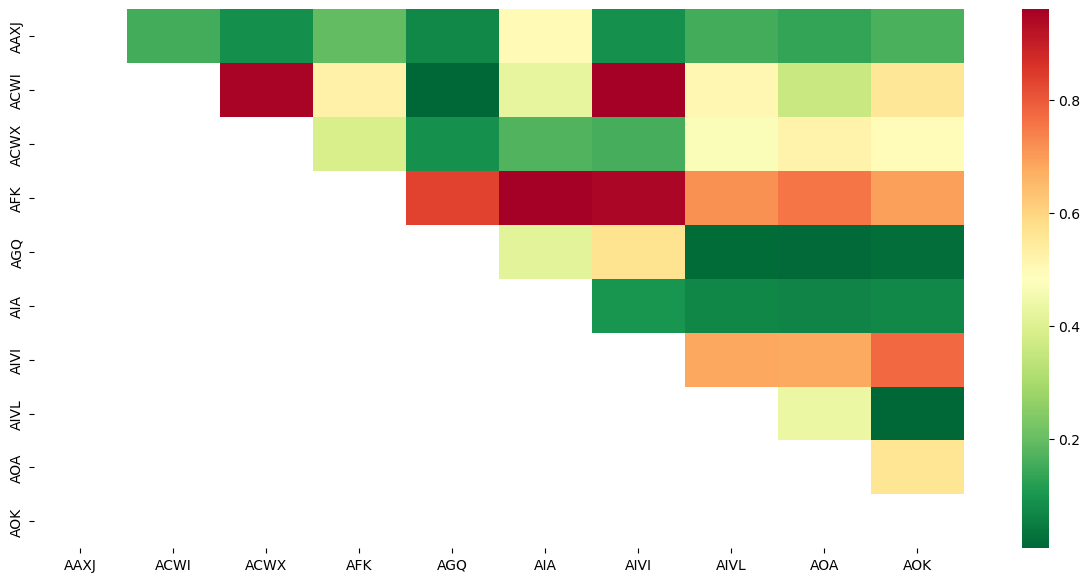

In [43]:
# Heatmap to show the p-values of the cointegration test between each pair of stocks
data = subset
scores, pvalues, pairs = find_cointegrated_pairs(data)

plt.figure(figsize=(15,7))

sns.heatmap(pvalues, xticklabels=data.columns, yticklabels=data.columns, cmap='RdYlGn_r', mask = (pvalues >= 1))

plt.show()

In [44]:
top_pairs = search_coint_pairs(subset, 0.05).head()
print(top_pairs)

      scores   pvalues        pairs
11 -4.016135  0.006810  (ACWI, AGQ)
43 -3.963683  0.008085  (AIVL, AOK)
33 -3.791599  0.013909   (AGQ, AOA)
32 -3.772412  0.014748  (AGQ, AIVL)
34 -3.653801  0.020986   (AGQ, AOK)


In [45]:
num = 0 # using the pair with the smallest p-value

P1 = top_pairs.iloc[num].pairs[0]
P2 = top_pairs.iloc[num].pairs[1]
print('Coin 1: {} vs Coin 2: {}'.format(P1, P2))

Coin 1: ACWI vs Coin 2: AGQ


In [47]:
def coint_for_pair(i, j, data, keys, conf):
    s1 = data.iloc[:, i]
    s2 = data.iloc[:, j]
    # coint returns (t_stat, pvalue, crit_vals)
    score, pvalue, _ = coint(s1, s2)
    # return everything needed to rebuild matrices / pairs
    return i, j, score, pvalue, (keys[i], keys[j]), (pvalue < conf)

def find_cointegrated_pairs_parallel(data, conf=0.05, n_jobs=-1):
    data = data.dropna()  # optional: ensures coint doesn't choke on NaNs
    n = data.shape[1]
    keys = list(data.columns)

    tuples = [(i, j) for i in range(n) for j in range(i+1, n)]

    results = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(coint_for_pair)(i, j, data, keys, conf)
        for i, j in tuples
    )

    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    pairs = []

    for i, j, score, pvalue, pair, is_coint in results:
        score_matrix[i, j] = score
        pvalue_matrix[i, j] = pvalue
        if is_coint:
            pairs.append(pair)

    return score_matrix, pvalue_matrix, pairs

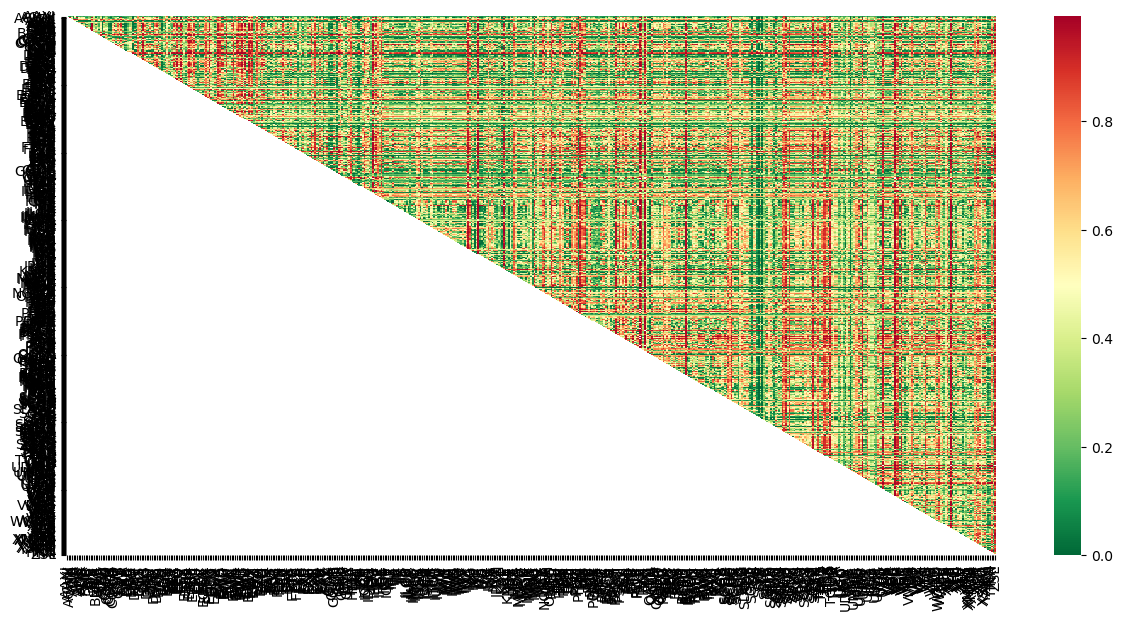

In [49]:
subset = log_prices_train.iloc[:, :]

scores, pvalues, pairs = find_cointegrated_pairs_parallel(subset, conf=0.05, n_jobs=-1)

plt.figure(figsize=(15,7))
sns.heatmap(pvalues, xticklabels=subset.columns, yticklabels=subset.columns,
            cmap='RdYlGn_r', mask=(pvalues >= 1))
plt.show()

In [53]:
symmap = pd.read_csv("data/symbol2name.csv")
sym2name = dict(zip(symmap["Symbol"], symmap["Security Name"]))

In [70]:
cols = list(subset.columns)
col_to_idx = {c:i for i,c in enumerate(cols)}

pairs_df = pd.DataFrame(pairs, columns=["sym1","sym2"])
pairs_df["pvalue"] = pairs_df.apply(
    lambda r: pvalues[col_to_idx[r["sym1"]], col_to_idx[r["sym2"]]],
    axis=1
)

pairs_df = pairs_df.sort_values("pvalue").reset_index(drop=True)
pairs_df.head(20)

,sym1,sym2,pvalue
0,IJK,MDYG,6.020077e-12
1,IJT,SLYG,4.498349e-10
2,IVE,SPYV,5.459201e-07
3,SPLG,VV,1.268721e-06
4,IGV,IHI,1.879112e-06
5,IWB,SPLG,3.298574e-06
6,FDN,QABA,5.346326e-06
7,EFG,PSP,5.451598e-06
8,PNQI,QABA,1.136172e-05
9,IOO,RFV,1.874561e-05


In [72]:
pairs_df["name1"] = pairs_df["sym1"].map(sym2name)
pairs_df["name2"] = pairs_df["sym2"].map(sym2name)
pairs_df[["sym1","name1","sym2","name2","pvalue"]].head(10)

,sym1,name1,sym2,name2,pvalue
0,IJK,iShares S&P Mid-Cap 400 Growth ETF,MDYG,State Street SPDR S&P 400 Mid Cap Growth ETF,6.020077e-12
1,IJT,iShares S&P SmallCap 600 Growth ETF,SLYG,State Street SPDR S&P 600 Small Cap Growth ETF,4.498349e-10
2,IVE,iShares S&P 500 Value ETF,SPYV,State Street SPDR Portfolio S&P 500 Value ETF,5.459201e-07
3,SPLG,NaN,VV,Vanguard Large-Cap ETF,1.268721e-06
4,IGV,iShares Expanded Tech-Software Sector ETF,IHI,iShares U.S. Medical Devices ETF,1.879112e-06
5,IWB,iShares Russell 1000 ETF,SPLG,NaN,3.298574e-06
6,FDN,First Trust DJ Internet Index Fund,QABA,First Trust NASDAQ ABA Community Bank Index Fund,5.346326e-06
7,EFG,iShares MSCI EAFE Growth ETF,PSP,Invesco Global Listed Private Equity ETF,5.451598e-06
8,PNQI,Invesco Nasdaq Internet ETF,QABA,First Trust NASDAQ ABA Community Bank Index Fund,1.136172e-05
9,IOO,iShares Global 100 ETF,RFV,Invesco S&P MidCap 400 Pure Value ETF,1.874561e-05
